In [9]:
%pip install factor-analyzer

     -------------------------------------- 42.8/42.8 kB 417.7 kB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for factor-analyzer: filename=factor_analyzer-0.5.1-py2.py3-none-any.whl size=42715 sha256=351feff16c423938fd7ad21691095fa744fd37fe30d7f6e34ee0fa9aaa70f865
  Stored in directory: c:\users\nataly rodriguez\appdata\local\pip\cache\wheels\18\c9\ed\e44135cf086e2c7f9f6d58cbb27c71bded3f88a9a9d4dcd48e
Successfully built factor-analyzer
Note: you may need to restart the kernel to use updated packages.


In [61]:
from sklearn.datasets import load_breast_cancer
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from yellowbrick.cluster import KElbowVisualizer
from sklearn.decomposition import PCA
import numpy as np
from factor_analyzer import FactorAnalyzer, calculate_kmo, calculate_bartlett_sphericity

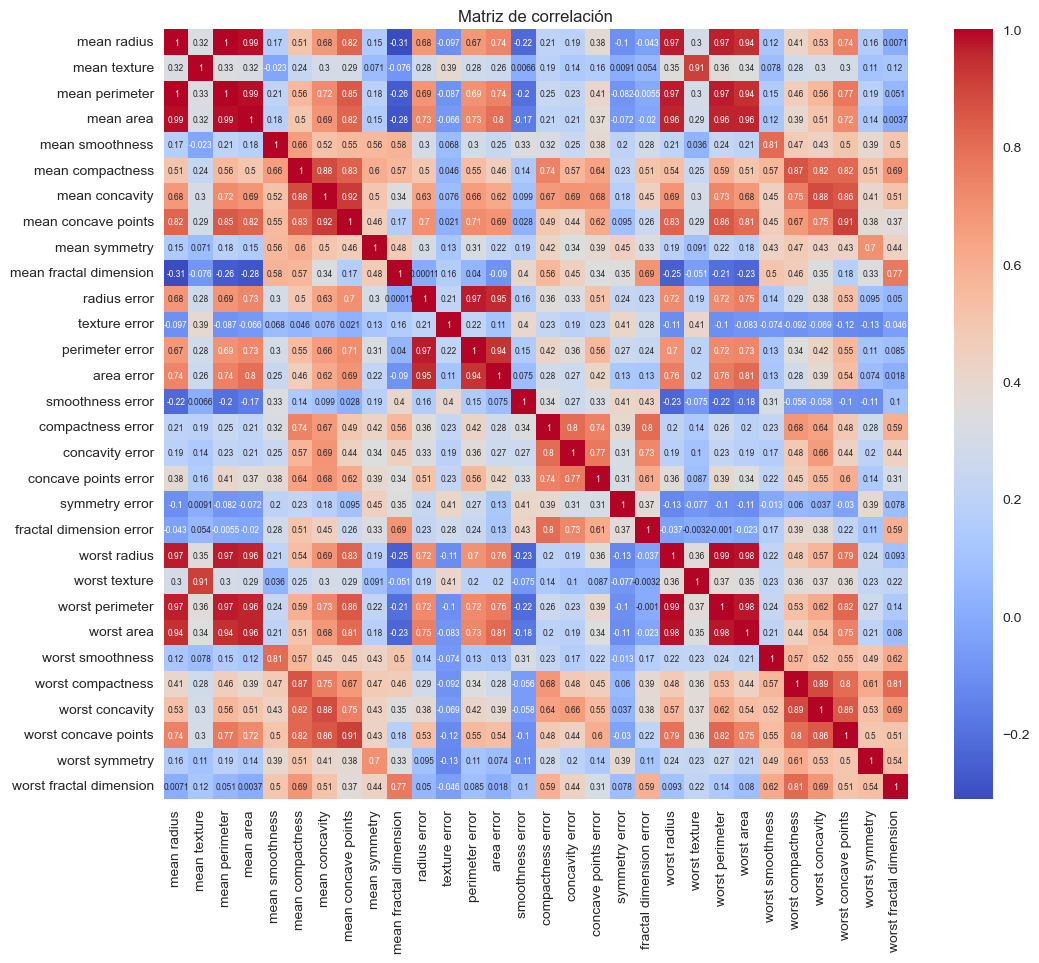

In [62]:
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)

# Matriz de correlación para evitar multicolinealidad
plt.figure(figsize=(12, 10))
correlation_matrix = X.corr()
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=True, annot_kws={"size": 6})
plt.title("Matriz de correlación")
plt.show()

Variables eliminadas por alta correlación: ['mean perimeter', 'mean area', 'mean concavity', 'mean concave points', 'perimeter error', 'area error', 'concavity error', 'concave points error', 'fractal dimension error', 'worst radius', 'worst texture', 'worst perimeter', 'worst area', 'worst smoothness', 'worst compactness', 'worst concavity', 'worst concave points', 'worst fractal dimension']


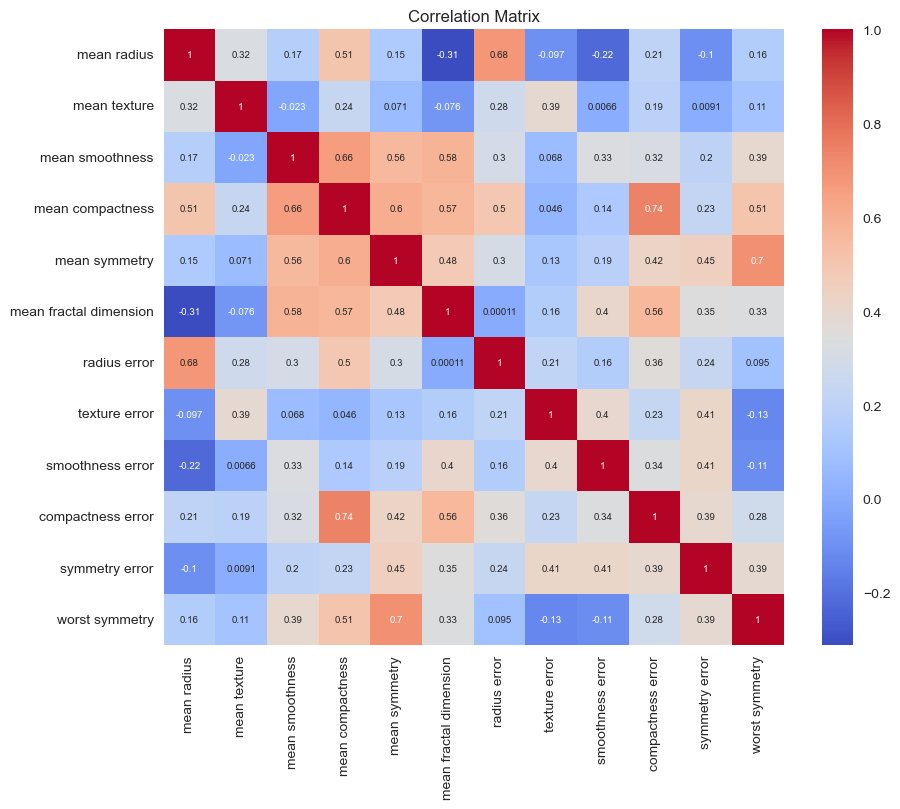

In [63]:
# Crear una lista para guardar las columnas que vamos a eliminar
to_drop = []
cor_matrix = correlation_matrix.abs()
# Revisamos cada par de columnas (sin repetir)
for i in range(len(cor_matrix.columns)):
    for j in range(i):
        if round(cor_matrix.iloc[i, j],1) >= 0.8:
            colname = cor_matrix.columns[i]
            if colname not in to_drop:
                to_drop.append(colname)

# Mostramos qué columnas se eliminarán
print("Variables eliminadas por alta correlación:", to_drop)

# Eliminamos las columnas de X
X_filtered = X.drop(columns=to_drop)

plt.figure(figsize=(10, 8))
sns.heatmap(X_filtered.corr(), annot=True, cmap='coolwarm', annot_kws={"size": 7})
plt.title("Correlation Matrix")
plt.show()

## **<span style="color:#1a73e8;">PCA</span>**

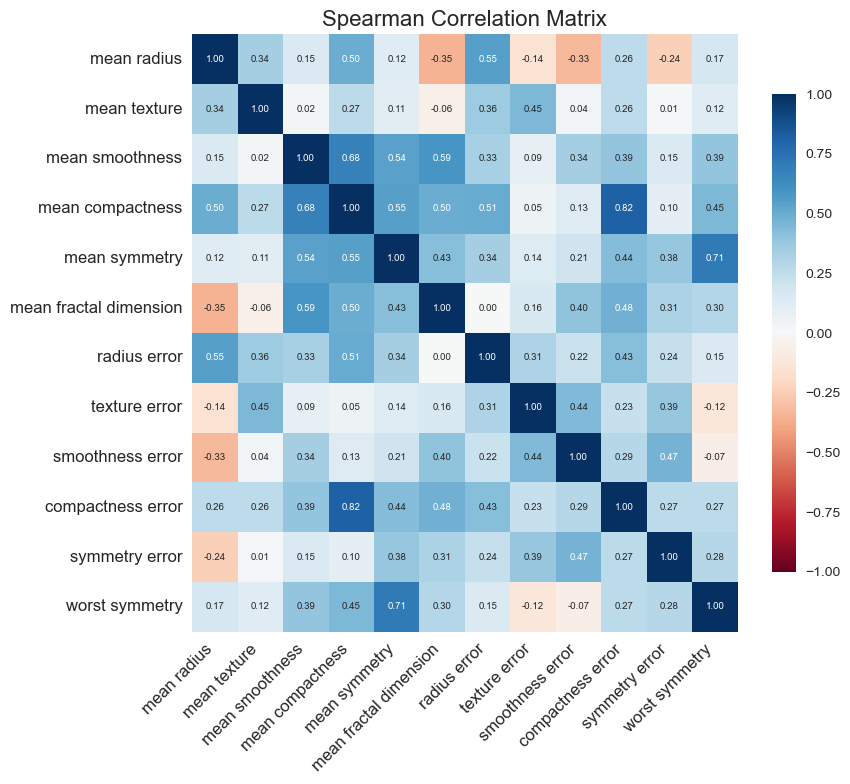


Spearman - Correlated Variables Table:
              Variable  Correlated Variables (≥ 0.5)  PCA Candidate
           mean radius                             2           True
          mean texture                             1           True
       mean smoothness                             3           True
      mean compactness                             7           True
         mean symmetry                             3           True
mean fractal dimension                             3           True
          radius error                             2           True
         texture error                             1           True
      smoothness error                             1           True
     compactness error                             2           True
        symmetry error                             1           True
        worst symmetry                             2           True


In [64]:
 # Matriz de correlación
spearman_corr = X_filtered.corr(method="spearman")
    
def create_correlation_heatmap(corr_matrix, title):
    plt.figure(figsize=(9, 8))
    ax = sns.heatmap(
        corr_matrix,
        annot=True,         
        fmt=".2f",          
        cmap="RdBu",        
        vmin=-1, vmax=1,    
        annot_kws={"size": 7},
        cbar_kws={"shrink": 0.8}
    )
    plt.title(title, fontsize=16)
    plt.xticks(rotation=45, ha="right", fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.show()
    

create_correlation_heatmap(spearman_corr, "Spearman Correlation Matrix")


"""Creates a table of highly correlated variables based on the threshold."""
method_name = 'Spearman'
threshold = 0.5
correlated_vars = (round(spearman_corr.abs(),1) >= threshold).sum() - 1  # Exclude self-correlation
correlated_table = pd.DataFrame({
         "Variable": correlated_vars.index,
        f"Correlated Variables (≥ {threshold:.1f})": correlated_vars.values
    })

correlated_table["PCA Candidate"] = correlated_table.iloc[:, 1] > 0
        
print(f"\n{method_name} - Correlated Variables Table:")
print(correlated_table.to_string(index=False))
      



Variables seleccionadas para PCA: ['mean radius', 'mean texture', 'mean smoothness', 'mean compactness', 'mean symmetry', 'mean fractal dimension', 'radius error', 'texture error', 'smoothness error', 'compactness error', 'symmetry error', 'worst symmetry']
Cantidad de variables seleccionadas: 12


Explained variance ratio: [0.35680423 0.17470287 0.14186187 0.08785151 0.07190487 0.0575598
 0.03578407 0.02525299 0.02153514 0.01287505 0.00973457 0.00413304]
Cumulative Explained variance ratio: [0.35680423 0.5315071  0.67336897 0.76122048 0.83312535 0.89068515
 0.92646922 0.95172221 0.97325735 0.9861324  0.99586696 1.        ]


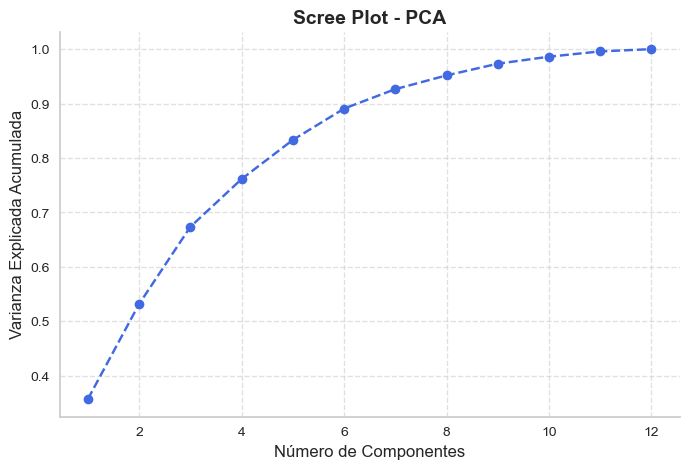

In [65]:
# Variables seleccionadas por PCA
pca_vars = correlated_table.loc[correlated_table["PCA Candidate"], "Variable"].tolist()
print("Variables seleccionadas para PCA:", pca_vars)
print("Cantidad de variables seleccionadas:", len(pca_vars))
print('\n')


# Estandarizar PCA
scaler = StandardScaler()
df_scaled = scaler.fit_transform(X_filtered[pca_vars])

# Aplicar PCA
pca = PCA()
principal_components = pca.fit_transform(df_scaled)

print("Explained variance ratio:", pca.explained_variance_ratio_)
print("Cumulative Explained variance ratio:", np.cumsum(pca.explained_variance_ratio_))

explained_variance = pca.explained_variance_ratio_

num_components = np.arange(1, len(explained_variance) + 1) 

plt.figure(figsize=(8, 5))
plt.plot(num_components,np.cumsum(explained_variance), marker="o", linestyle="--", color="royalblue")
plt.xlabel("Número de Componentes")
plt.ylabel("Varianza Explicada Acumulada")
plt.title("Scree Plot - PCA", fontsize=14, fontweight="bold")
plt.grid(True, linestyle="--", alpha=0.6)
sns.despine()
plt.show()

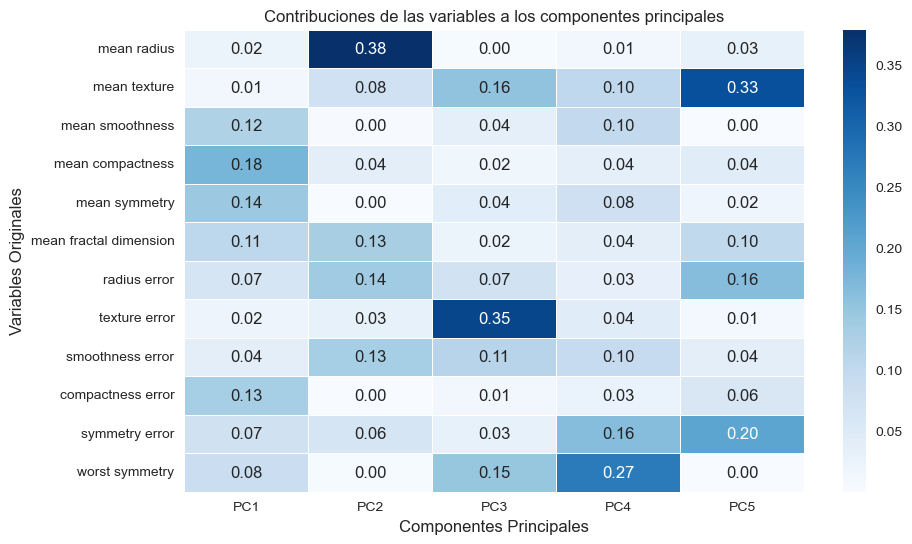

In [66]:
# Crear un nuevo Data Frame con los valores de PC
num_pcs = 5
pc_columns = [f"PC{i+1}" for i in range(num_pcs)]
df_pca = pd.DataFrame(principal_components[:, :num_pcs], columns=pc_columns, index=X_filtered.index)


df_final = pd.concat([X_filtered, df_pca], axis=1)
df_final = df_final.reset_index(drop=True)

# Contribución de los componentes principales
# Cada variable contribuye en distinta medida a cada componente principal.
# El cálculo que realizamos muestra qué porcentaje aporta cada variable dentro de un componente.
# Por ejemplo, si la variable "edad" aporta 0.5 en el PC1, significa que explica el 50% de la información de ese componente.
# La suma de todas las contribuciones para un mismo componente es 100% (o 1 en proporción),
# porque el componente está formado por la combinación de todas las variables.
loadings = pca.components_  # Loadings (eigenvectors)
contributions = (loadings**2) / np.sum(loadings**2, axis=1, keepdims=True)   # Contributions 

contributions_df = pd.DataFrame(contributions.T, index=pca_vars, columns=[f"PC{i+1}" for i in range(contributions.shape[0])])
contributions_to_plot = contributions_df.iloc[:, :num_pcs]

plt.figure(figsize=(10, 6))
sns.heatmap(contributions_to_plot, annot=True, cmap="Blues", fmt=".2f", linewidths=0.5)
plt.xlabel("Componentes Principales")
plt.ylabel("Variables Originales")
plt.title("Contribuciones de las variables a los componentes principales")
plt.show()

In [67]:
display(df_final)

,mean radius,mean texture,mean smoothness,mean compactness,mean symmetry,mean fractal dimension,radius error,texture error,smoothness error,compactness error,symmetry error,worst symmetry,PC1,PC2,PC3,PC4,PC5
0,17.99,10.38,0.11840,0.27760,0.2419,0.07871,1.0950,0.9053,0.006399,0.04904,0.03003,0.4601,5.543137,0.738251,-2.711063,-0.540090,1.578245
1,20.57,17.77,0.08474,0.07864,0.1812,0.05667,0.5435,0.7339,0.005225,0.01308,0.01389,0.2750,-1.208464,2.047397,-0.385580,-0.228784,0.836364
2,19.69,21.25,0.10960,0.15990,0.2069,0.05999,0.7456,0.7869,0.006150,0.04006,0.02250,0.3613,2.123361,2.075007,-0.716516,0.085351,0.504816
3,11.42,20.38,0.14250,0.28390,0.2597,0.09744,0.4956,1.1560,0.009110,0.07458,0.05963,0.6638,9.435532,-2.756723,-3.295330,2.663523,-0.245244
4,20.29,14.34,0.10030,0.13280,0.1809,0.05883,0.7572,0.7813,0.011490,0.02461,0.01756,0.2364,0.399491,1.164189,0.262377,-2.094354,1.763510
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,0.11100,0.11590,0.1726,0.05623,1.1760,1.2560,0.010300,0.02891,0.01114,0.2060,0.724627,2.679543,1.894711,-2.301037,0.956522
565,20.13,28.25,0.09780,0.10340,0.1752,0.05533,0.7655,2.4630,0.005769,0.02423,0.01898,0.2572,0.425569,2.281721,2.815112,0.621859,-0.417228
566,16.60,28.08,0.08455,0.10230,0.1590,0.05648,0.4564,1.0750,0.005903,0.03731,0.01318,0.2218,-0.961417,1.786364,1.423439,-0.215078,-1.450028
567,20.60,29.33,0.11780,0.27700,0.2397,0.07016,0.7260,1.5950,0.006522,0.06158,0.02324,0.4087,5.337420,2.287453,-0.082106,0.632352,-1.647767


## **<span style="color:#1a73e8;">FACTOR ANÁLISIS</span>**

✔ ***Medida Kaiser-Meyer-Olkin (KMO)***

La medida KMO evalúa si las variables comparten suficiente varianza común como para aplicar análisis factorial. Su valor va de 0 a 1, donde valores más altos indican mayor adecuación del modelo.

Interpretación de KMO:

0.00 – 0.49: Inaceptable

0.50 – 0.59: Débil

0.60 – 0.69: Regular

0.70 – 0.79: Bueno

0.80 – 1.00: Excelente

Un KMO alto significa que los patrones de correlación son apropiados para extraer factores. Si el KMO es bajo, es aconsejable revisar variables o considerar más datos.

✔ ***Test de Esfericidad de Bartlett***

El test de Bartlett verifica si existen correlaciones significativas entre las variables. Prueba la hipótesis nula de que la matriz de correlaciones es una matriz identidad, es decir, sin relaciones entre variables.

Interpretación:

p < 0.05: Hay correlaciones significativas → el análisis factorial es adecuado.

p ≥ 0.05: No hay suficientes correlaciones → el análisis factorial no es recomendable.

In [68]:
df_num = X_filtered.select_dtypes(include=['float64', 'int64'])

df_scaled = pd.DataFrame(StandardScaler().fit_transform(df_num),
                         columns=df_num.columns)

# Verificar si el análisis factorial es adecuada 
kmo_all, kmo_model = calculate_kmo(df_scaled)
print("KMO:", kmo_model) 

# Debe ser p < 0.05
chi_square, p_value = calculate_bartlett_sphericity(df_scaled)
print("Bartlett p-value:", p_value)

KMO: 0.6425710006877663
Bartlett p-value: 0.0


[4.28165078 2.09643446 1.70234243 1.0542181  0.86285839 0.69071761
 0.42940887 0.30303587 0.25842165 0.15450059 0.11681478 0.04959647]


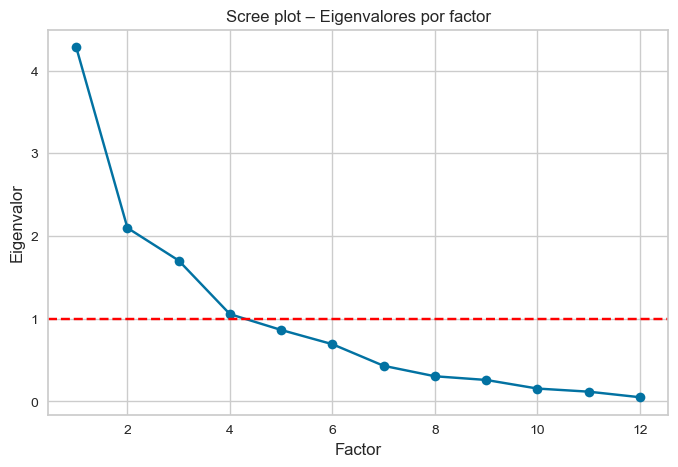

In [69]:
fa = FactorAnalyzer(n_factors=df_scaled.shape[1], rotation=None)
fa.fit(df_scaled)

eigenvalues, v = fa.get_eigenvalues()
print(eigenvalues)


plt.figure(figsize=(8,5))
plt.plot(range(1, len(eigenvalues)+1), eigenvalues, marker='o')
plt.title('Scree plot – Eigenvalores por factor')
plt.xlabel('Factor')
plt.ylabel('Eigenvalor')
plt.axhline(1, color='red', linestyle='--')
plt.grid(True)
plt.show()

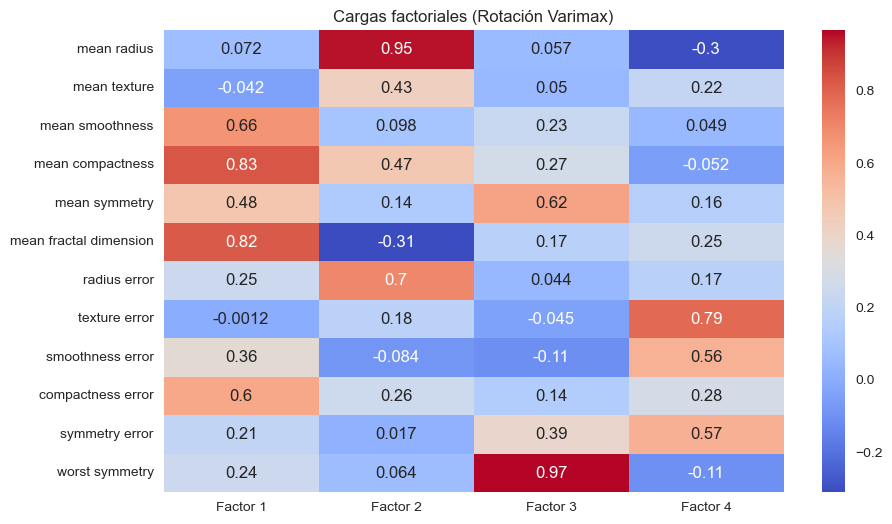

In [70]:
n_factors = 4
fa = FactorAnalyzer(n_factors=n_factors, rotation='varimax')
fa.fit(df_scaled)

loadings = pd.DataFrame(
    fa.loadings_,
    index=df_scaled.columns,
    columns=[f'Factor {i+1}' for i in range(n_factors)]
)

loadings

plt.figure(figsize=(10,6))
sns.heatmap(loadings, annot=True, cmap='coolwarm')
plt.title("Cargas factoriales (Rotación Varimax)")
plt.show()

In [71]:
scores = pd.DataFrame(
    fa.transform(df_scaled),
    columns=[f'Factor {i+1}' for i in range(n_factors)]
)

scores.head()

,Factor 1,Factor 2,Factor 3,Factor 4
0,3.469932,0.771964,2.390418,-0.862846
1,-0.957712,1.610723,-0.236232,-1.088406
2,-0.026202,1.211366,1.024599,-0.576724
3,3.015383,-1.298592,5.513809,0.770030
4,0.783901,1.710220,-1.098776,-0.734442


## **<span style="color:#1a73e8;">CLUSTER</span>**

In [72]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   mean radius             569 non-null    float64
 1   mean texture            569 non-null    float64
 2   mean smoothness         569 non-null    float64
 3   mean compactness        569 non-null    float64
 4   mean symmetry           569 non-null    float64
 5   mean fractal dimension  569 non-null    float64
 6   radius error            569 non-null    float64
 7   texture error           569 non-null    float64
 8   smoothness error        569 non-null    float64
 9   compactness error       569 non-null    float64
 10  symmetry error          569 non-null    float64
 11  worst symmetry          569 non-null    float64
 12  PC1                     569 non-null    float64
 13  PC2                     569 non-null    float64
 14  PC3                     569 non-null    fl

In [75]:
X = df_final[['PC1', 'PC2', 'PC3', 'PC4', 'PC5']]
# 📌 Paso 2: Aplicar K-Means clustering
kmeans = KMeans(n_clusters=2, random_state=42)
labels = kmeans.fit_predict(X)  # fit_predict devuelve directamente las etiquetas

# Añadimos los labels al DataFrame original (sin escalar)
X_plot = X.copy()
X_plot['cluster'] = labels

# 📌 Paso 3: Visualizar en dos variables poco correlacionadas
var1 = X_plot.columns[0]
var2 = X_plot.columns[1]

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=X_plot,
    x=var1,
    y=var2,
    hue='cluster',
    palette='Set1'
)
plt.title("Clustering usando K-Means")
plt.xlabel(var1)
plt.ylabel(var2)
plt.legend(title='Cluster asignado')
plt.tight_layout()
plt.grid(True)
plt.show()

AttributeError: 'NoneType' object has no attribute 'split'

Index(['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'cluster'], dtype='object')
Distribución de la variable real 'target' (tipo de tumor) dentro de cada clúster:
cluster  target
0        0         0.709497
         1         0.290503
1        1         0.782051
         0         0.217949
Name: proportion, dtype: float64


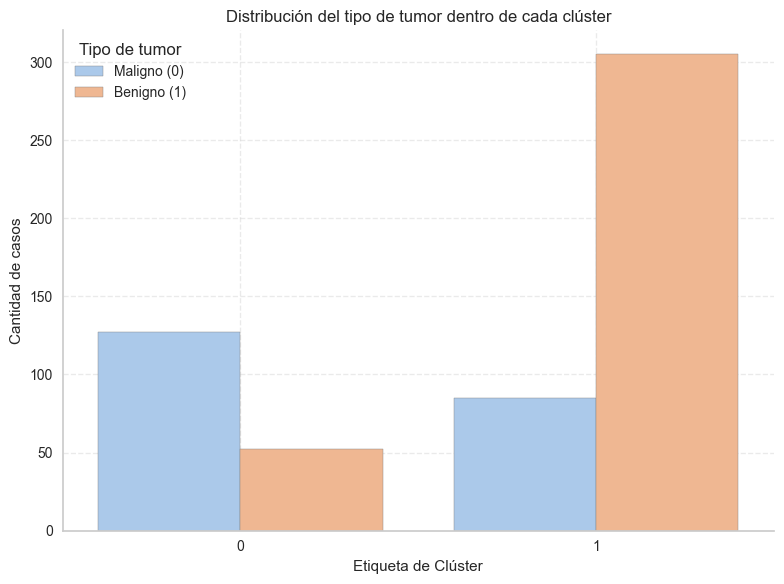

In [32]:
# 📌 Paso 1: Ver la proporción de etiquetas reales ('maligno' o 'benigno') dentro de cada clúster
# Esto nos ayuda a ver qué tan homogéneo es cada grupo.
df = X_plot.copy()
print(df.columns)

df['target'] = data.target  
cluster_stats = df.groupby('cluster')['target'].value_counts(normalize=True)

print("Distribución de la variable real 'target' (tipo de tumor) dentro de cada clúster:")
print(cluster_stats)

# 📌 Paso 2: Gráfico de barras para comparar la distribución de 'target' en cada clúster

plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='cluster', hue='target', palette='pastel', edgecolor='gray')
plt.title('Distribución del tipo de tumor dentro de cada clúster')
plt.xlabel('Etiqueta de Clúster')
plt.ylabel('Cantidad de casos')
plt.legend(title='Tipo de tumor', labels=['Maligno (0)', 'Benigno (1)'])
plt.grid(True, linestyle="--", alpha=0.4)
sns.despine()
plt.tight_layout()
plt.show()